In [2]:
from openmm.app import *
from openmm import *
from simtk.unit import *
import MDAnalysis as md
import nglview as ng
from sys import stdout
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pdb0_file = '../../data/md_tutorial/villin_water.pdb'
pdb1_file = '../../data/md_tutorial/polyALA.pdb'
pdb2_file = '../../data/md_tutorial/polyGLY.pdb'
pdb3_file = '../../data/md_tutorial/polyGV.pdb'

In [4]:
# show original polyGV
ng.show_mdanalysis(md.Universe(pdb3_file), gui=True)

NGLWidget()

In [4]:
### 1.loading initial coordinates
pdb = PDBFile(pdb3_file)

### 2.choosing a forcefield parameters
ff = ForceField('amber10.xml')
system = ff.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic)

### 3. Choose parameters of the experiment: temperature, pressure, box size, solvation, boundary conditions, etc
temperature = 300 * kelvin
frictionCoeff = 1 / picosecond
time_step = 0.002 * picoseconds
total_steps = 400 * picoseconds / time_step

### 4. Choose an algorithm (integrator)
integrator = LangevinIntegrator(temperature, frictionCoeff, time_step)

### 5. Run simulation, saving coordinates time to time:

### 5a. Create a simulation object
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

### 5b. Minimize energy
simulation.minimizeEnergy()

### 5c. Save coordinates to dcd file and energies to a standard output console:
simulation.reporters.append(DCDReporter('../../data/md_tutorial/output/polyALA_traj.dcd', 1000))
simulation.reporters.append(StateDataReporter(stdout, 5000, step=True, potentialEnergy=True,\
                                              temperature=True, progress=True, totalSteps = total_steps))

### 5d. Run!
simulation.step(total_steps)

#"Progress (%)","Step","Potential Energy (kJ/mole)","Temperature (K)"
2.5%,5000,3814.111328125,305.60464395823965
5.0%,10000,3713.037353515625,323.5462672287275
7.5%,15000,3671.787109375,311.0787653374847
10.0%,20000,3606.669921875,304.3269898120267
12.5%,25000,3518.508544921875,313.292859509804
15.0%,30000,3530.89599609375,306.8879200816996
17.5%,35000,3388.803955078125,304.81725871781197
20.0%,40000,3440.65478515625,309.3395562145557
22.5%,45000,3393.005126953125,309.01850882399225
25.0%,50000,3330.2412109375,310.8829757485919
27.5%,55000,3309.85400390625,285.64658003059367
30.0%,60000,3405.71044921875,308.4134255695714
32.5%,65000,3300.7216796875,309.56112082149366
35.0%,70000,3213.78466796875,309.46385724252383
37.5%,75000,3424.017578125,310.6339191701898
40.0%,80000,3261.1806640625,306.3793705774822
42.5%,85000,3265.793701171875,295.25067077152306
45.0%,90000,3304.24169921875,307.65914317047003
47.5%,95000,3298.984130859375,305.2308898601532
50.0%,100000,3197.71875,303.38883867474

In [5]:
### 6. Visualization
sys = md.Universe(pdb3_file, '../../data/md_tutorial/output/polyALA_traj.dcd')
ng.show_mdanalysis(sys, gui=True)

NGLWidget(max_frame=199)

In [56]:
### analysis of end-to-end distance

## choose terminal atoms
N_terminus = sys.select_atoms('resid 1 and name N')  # topology 是 pdb3_file 文件, 里面有残基编号和原子名称
C_terminus = sys.select_atoms('resid 25 and name C')

print(N_terminus.positions)
print(C_terminus.positions)

## go through the whole trajectory and compute distance between them for every frame
dist = []
for frame in sys.trajectory:
    dist.append(np.linalg.norm(N_terminus.positions - C_terminus.positions))

## the result is in the dist array
dist = np.array(dist)
print(dist.shape)

[[-38.919662 -28.094826  -4.498993]]
[[29.506464  18.063238   0.3586283]]
(200,)


In [57]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

## compute information about hbonds and write it to the 'hb.timeseries'
hb = HBA(
  universe=sys,
  donors_sel='resname VAL',
  hydrogens_sel='resname ALA1 ALA7 and name H1 H2 H3 H',
  acceptors_sel='resname ALA2 ALA5 and name O',
  d_h_cutoff=1.2
)
hb.run()

# ## print information for the first 10 frames
# for frame in hb.timeseries[:10]:
#     print(frame)

print(hb.results.hbonds)

[]


In [46]:
## go through the 'hb.timeseries' file and calculate number of bonds for each time frame
## (it's the length of array frame)
hb_number = []
for frame in hb.timeseries:
    hb_number.append(len(frame))

## the result is in the number array
hb_number = np.array(hb_number)

AttributeError: 'HydrogenBondAnalysis' object has no attribute 'timeseries'

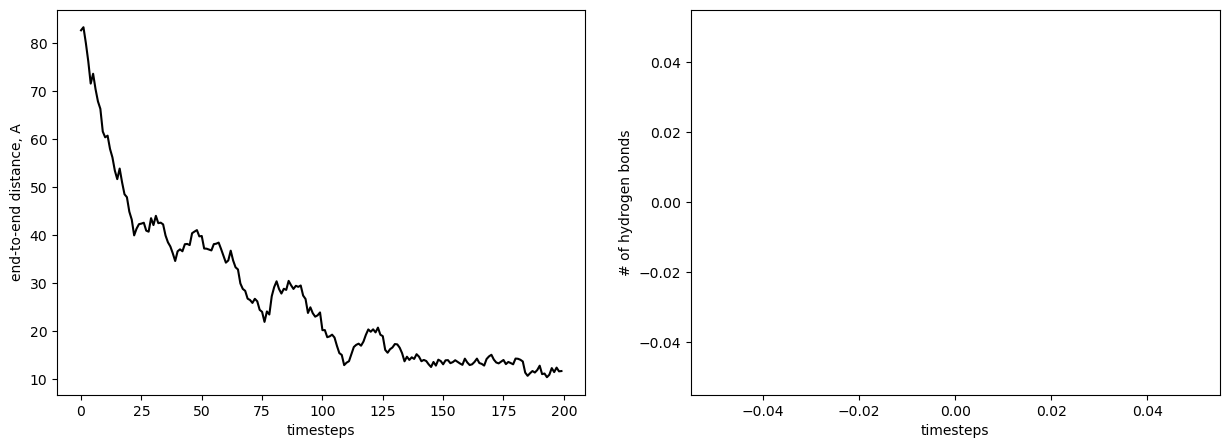

In [49]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(dist, '-k')
plt.xlabel('timesteps')
plt.ylabel('end-to-end distance, A')

plt.subplot(122)
plt.plot(hb_number, 'g-')
plt.ylabel('# of hydrogen bonds')
plt.xlabel('timesteps')

plt.show()

Text(30, 150, 'beta region')

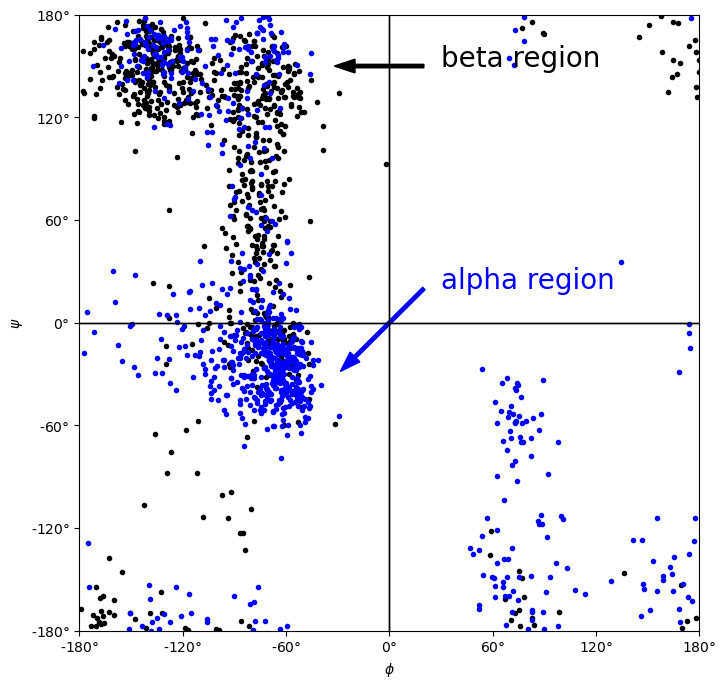

In [64]:
from MDAnalysis.analysis import dihedrals  ## module for dihedrals analysis

ram1 = dihedrals.Ramachandran(sys).run(0, 30)  ## analyse for first 30 steps (black color)
ram2 = dihedrals.Ramachandran(sys).run(170, 200)  ## analyse for last 30 steps (blue color)
print(ram1)
print(ram2)

## ramachandran plot
fig, ax = plt.subplots(figsize=(8, 8))
ram1.plot(ax=ax, color='k', marker='.')
ram2.plot(ax=ax, color='b', marker='.')
ax.arrow(20, 20, -40, -40, width=2, head_width=8, head_length=12, fc='b', ec='b')
ax.text(30, 20, 'alpha region', color='blue', fontsize=20)
ax.arrow(20, 150, -40, 0, width=2, head_width=8, head_length=12, fc='k', ec='k')
ax.text(30, 150, 'beta region', fontsize=20)